# Run-time Evaluation

We'll start with our standard set of initial imports

In [1]:
%matplotlib inline

import sys
import math
import outliers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

prescription = pd.read_csv('data/prescriptions_sample.csv.gz', compression='gzip')

In [2]:
medications = outliers.getOverdoseMedications(prescription)
medications.shape

(21,)

## Run-time Folds

For each medication (with more than 10K records) we split the data in 10 fold of 1K.

In each iteration we increase 1K records and run the algorithm again.

We compute the mean time for 3 medications

In [3]:
all_times  = []

for med in np.asarray(medications):

    methods_time = pd.DataFrame()
    
    X, Y = outliers.getPrescriptions(prescription, med)
    anomalies = len(Y[Y==1])
    total = len(X)
    
    if len(X) < 10000:
        continue

    print('')
    print(med + ', Size: ', total, ' Overdose: ', anomalies)
        
    index_list = np.append([], [])
    skf = StratifiedKFold(n_splits=anomalies)
    div = 1
    for train_index, test_index in skf.split(X, Y):
            
            
        index_list = np.append(index_list.astype(int), test_index.astype(int))
        size = len(index_list)
            
        X_train = X[index_list]
        Y_train = Y[index_list]
        overdose_size = len(Y_train[Y_train==1])
        
        if (size // 1000) < div:
            continue
            
        size_idx = div * 1000
        div = 1 + (size // 1000)
        
        sys.stdout.write(str(overdose_size) + '/' + str(size) +', ')
            
        epsilon = 0.5
        results = outliers.evaluateMethods(X_train, Y_train, epsilon, debug=False)

        for idx in results.index:
            methods_time.loc[idx, size_idx] = results.loc[idx,'Time']

        if size > 10000:
            break

    all_times.append(methods_time)
        #break
    
    if len(all_times) > 5:
        break
            
print('Done')


ANLODIPINO, Size:  10392  Overdose:  38
4/1096, 8/2192, 11/3014, 15/4110, 19/5205, 22/6024, 26/7116, 30/8208, 33/9027, 37/10119, 
CETOPROFENO, Size:  10907  Overdose:  45
5/1215, 9/2187, 13/3159, 17/4131, 21/5099, 25/6067, 29/7035, 33/8003, 38/9213, 42/10181, 
PARACETAMOL, Size:  10811  Overdose:  25
3/1299, 5/2165, 7/3031, 10/4330, 12/5195, 14/6059, 17/7355, 19/8219, 21/9083, 24/10379, Done


## One Table Result

In [4]:
all_times[1]

,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000
Cov,0.237,0.269,0.292,0.313,0.334,0.364,0.379,0.407,0.432,0.472
IsoF,0.146,0.195,0.233,0.277,0.316,0.360,0.397,0.436,0.497,0.534
Gau,0.004,0.006,0.006,0.007,0.008,0.009,0.009,0.010,0.011,0.019
DDC,0.019,0.024,0.023,0.024,0.026,0.026,0.027,0.027,0.029,0.055
SVM,0.027,0.078,0.153,0.266,0.397,0.567,0.757,0.999,1.482,1.722
LOF,0.143,0.290,0.421,0.587,0.761,0.935,1.123,1.375,1.640,1.859
DDC-J,0.017,0.021,0.022,0.022,0.025,0.024,0.025,0.026,0.027,0.027
DDC-C,0.021,0.027,0.028,0.029,0.034,0.034,0.035,0.035,0.036,0.036
DDC-H,0.019,0.023,0.024,0.025,0.026,0.026,0.027,0.028,0.029,0.029


## Mean Table Result

In [5]:
mean_time = pd.DataFrame(np.zeros((9,10)), index=results.index, columns=np.arange(1000,10001,1000))

for df in all_times:
    for m in df.index:
        for s in df.columns:
            mean_time.loc[m,s] += df.loc[m,s]

mean_time = ( mean_time.values / len(all_times) )
mean_time = pd.DataFrame(mean_time, index=results.index, columns=np.arange(1000,10001,1000))
mean_time

,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000
Cov,0.240667,0.272000,0.295333,0.319000,0.344000,0.373333,0.392000,0.419333,0.443000,0.475000
IsoF,0.150667,0.201333,0.240667,0.296000,0.342667,0.385667,0.445000,0.490667,0.547000,0.602000
Gau,0.005667,0.007000,0.008000,0.009333,0.011000,0.011333,0.014333,0.016333,0.017333,0.020000
DDC,0.025333,0.030333,0.032000,0.034333,0.037333,0.039333,0.043000,0.046000,0.047667,0.060000
SVM,0.031333,0.093000,0.180000,0.338667,0.528667,0.698667,1.000333,1.303333,1.694000,2.111000
LOF,0.124000,0.257333,0.379333,0.553000,0.705000,0.853000,1.029333,1.240667,1.424000,1.648000
DDC-J,0.022333,0.026333,0.028000,0.029333,0.031667,0.033000,0.036333,0.038333,0.039000,0.041000
DDC-C,0.032333,0.040000,0.044000,0.047333,0.053667,0.057000,0.074333,0.070000,0.071000,0.078667
DDC-H,0.026333,0.031000,0.033667,0.035333,0.039333,0.041333,0.046000,0.050333,0.051333,0.055333


## Run-time Plot

Here we plot the running time for each algorithm

Look that SVM and LOF have a exponential time for the number of instances

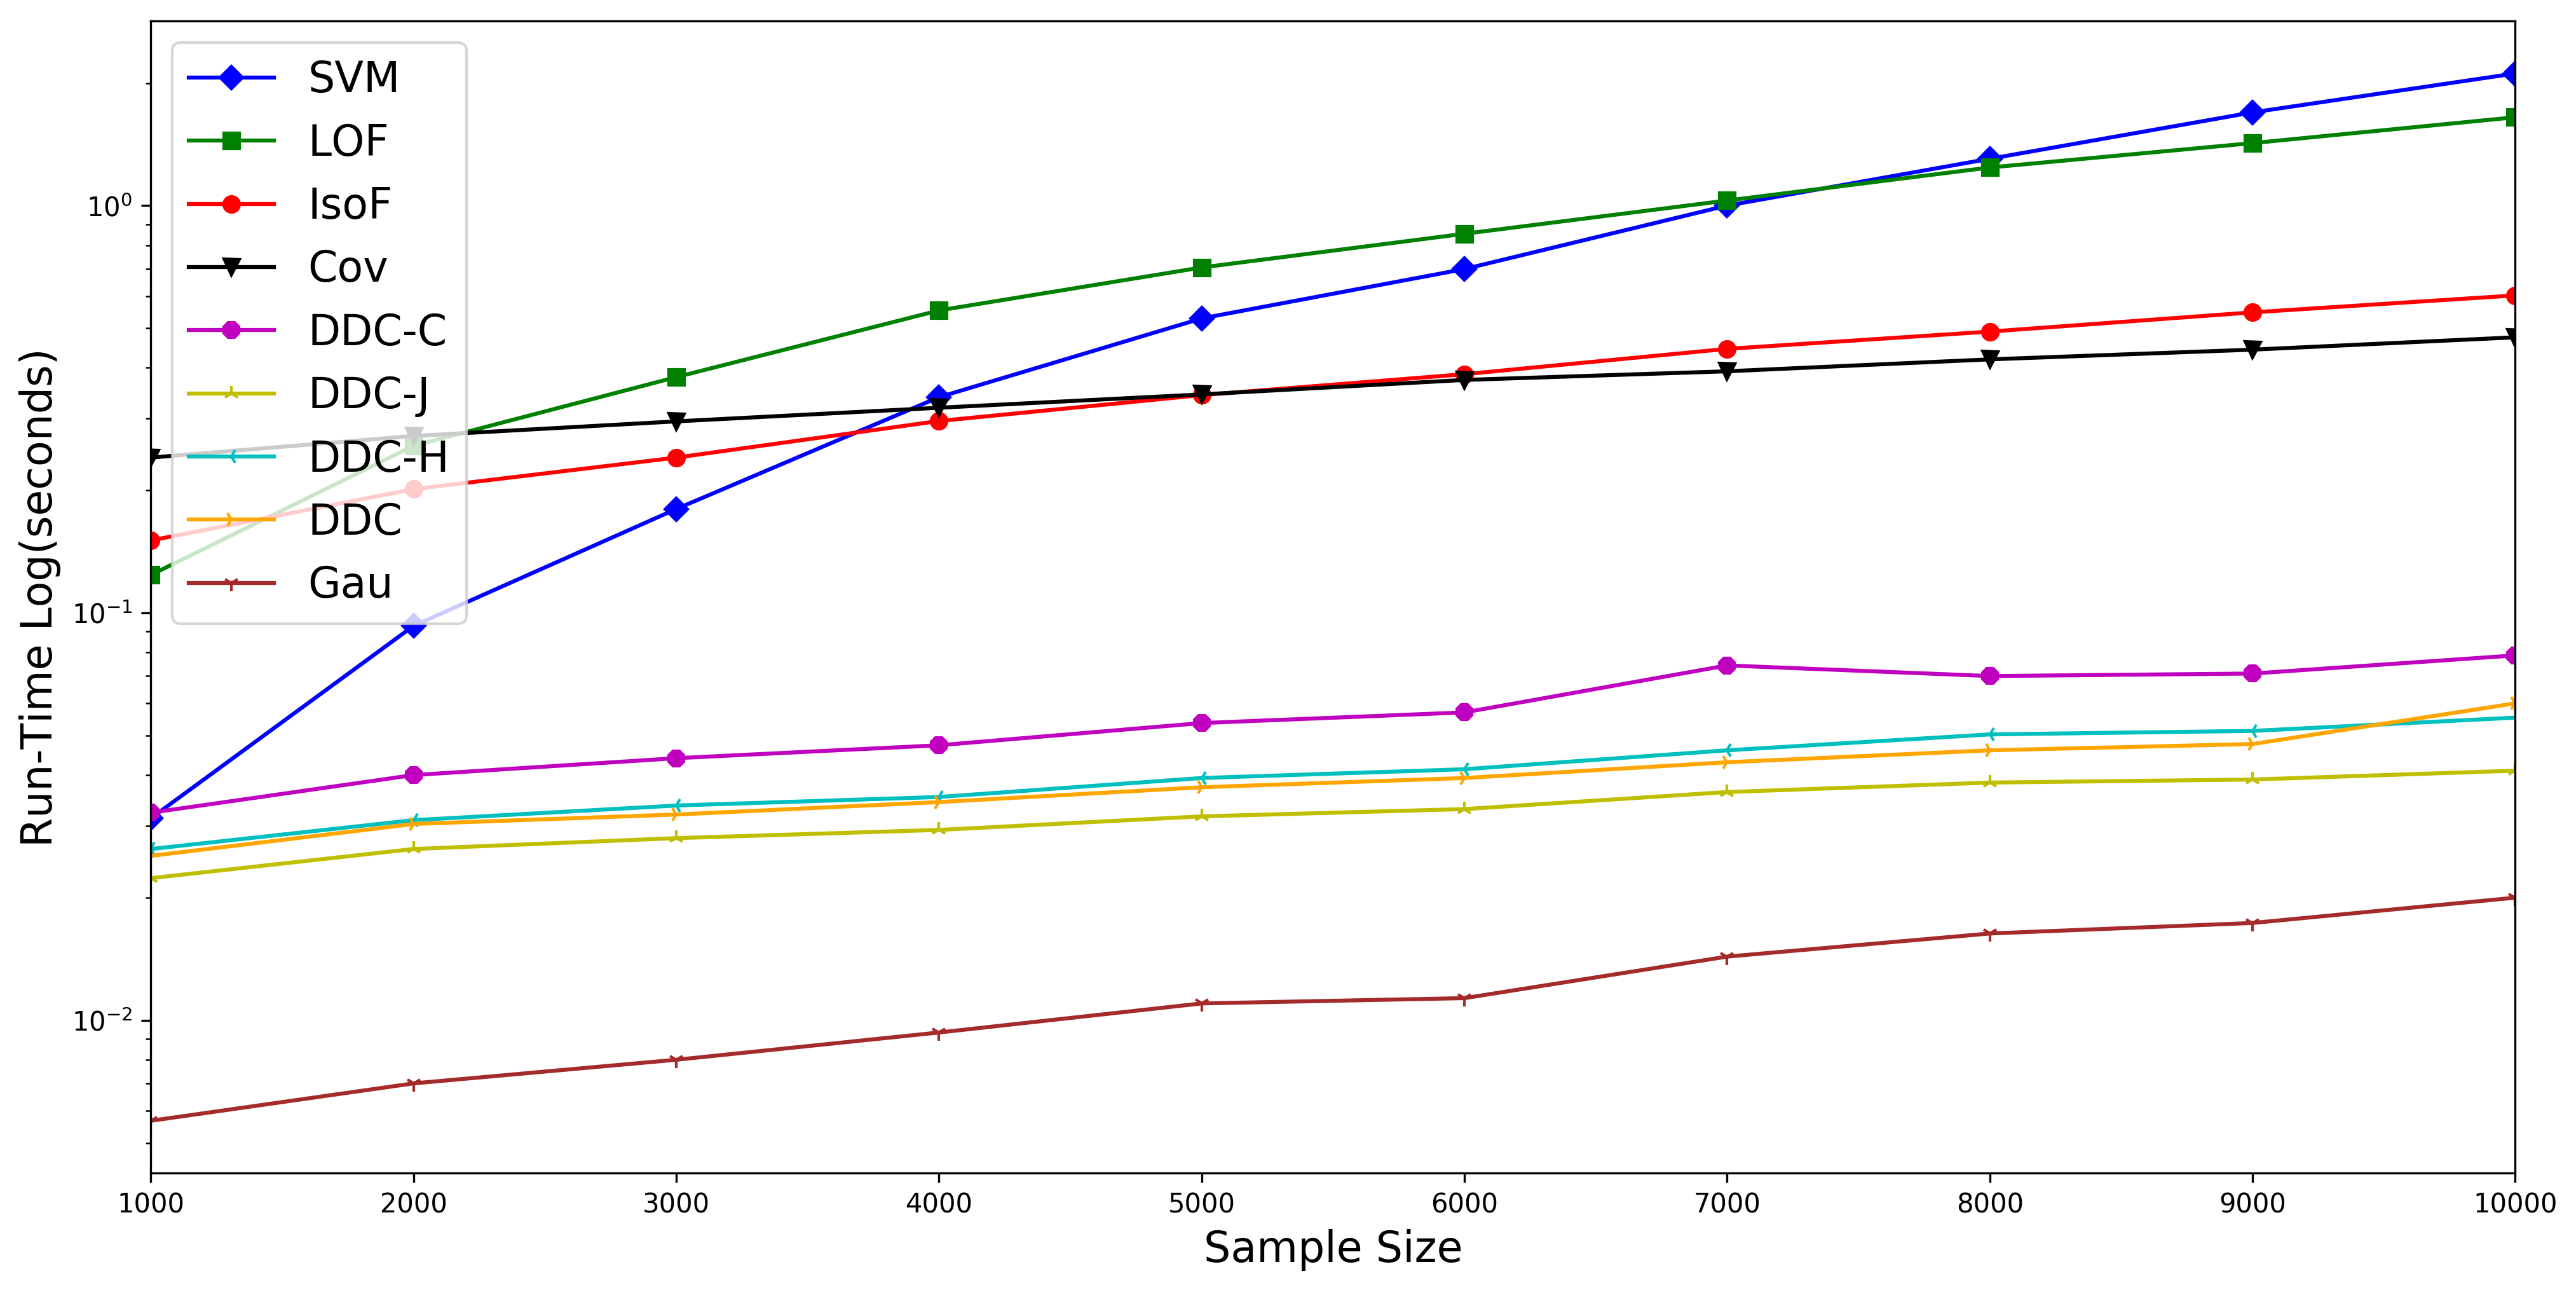

In [7]:
plt.figure(figsize=(16, 8), dpi= 300)
methods = ['SVM','LOF','IsoF','Cov','DDC-C','DDC-J','DDC-H','DDC','Gau']
colors = ['b', 'g', 'r', 'k', 'm', 'y', 'c', 'orange', 'brown']
markers = ['D', 's', 'o', 'v', '8', '2', '3', '4', '1']
i = 0
for m in methods:
    plt.plot(np.asarray(mean_time.columns),np.asarray(mean_time.loc[m].values), 
             c=colors[i],
             marker=markers[i],
             label=m)
    i += 1
    
plt.legend(fontsize=16)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Run-Time Log(seconds)', fontsize=16)
plt.yscale('log')
plt.xlim(1000,10000)
plt.show()